# Linear Regression Exercise
이 연습에서는 경사강하(gradient descent)를 사용하여 간단한 선형 회귀를 구현하고, 이를 예제 문제에 적용합니다. 또한 구현을 확장하여 다수의 변수를 갖는 선형회귀를 처리하고, 좀 더 어려운 예제에 적용 할 것입니다.

### 단변량 선형회귀 (univariate linear regression)
연습의 첫 번째 부분에서는 푸드 트럭의 이익을 예측하기 위해 변수 하나를 사용하여 선형 회귀를 구현해야 합니다. 당신이 레스토랑 프랜차이즈의 CEO이고, 새로운 매장을 열 다른 도시를 고려한다고 가정 해보십시오. 체인에는 이미 여러 도시에 트럭이 있으며, 도시의 이익과 인구에 대한 데이터가 있습니다.

먼저 일부 라이브러리를 가져 와서, 데이터를 검사해 봅시다. ex1data1.txt 파일에는 선형 회귀 문제에 대한 데이터 집합이 포함되어 있습니다. 첫 번째 열은 도시의 인구이며 두 번째 열은 그 도시의 푸드 트럭의 수익입니다. 이익에 대한 음수 값은 손실을 나타냅니다.

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
path = os.getcwd() + '/data/ex1data1.txt'   # on Window use '\data\ex1data1.txt'
data = pd.read_csv(path, header=None, names=['Population', 'Profit'])
data.head()

,Population,Profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


In [58]:
data.describe()

,Population,Profit
count,97.000000,97.000000
mean,8.159800,5.839135
std,3.869884,5.510262
min,5.026900,-2.680700
25%,5.707700,1.986900
50%,6.589400,4.562300
75%,8.578100,7.046700
max,22.203000,24.147000


데이터가 어떻게 생겼는 지를 더 잘 이해하기 위해 그려보자.

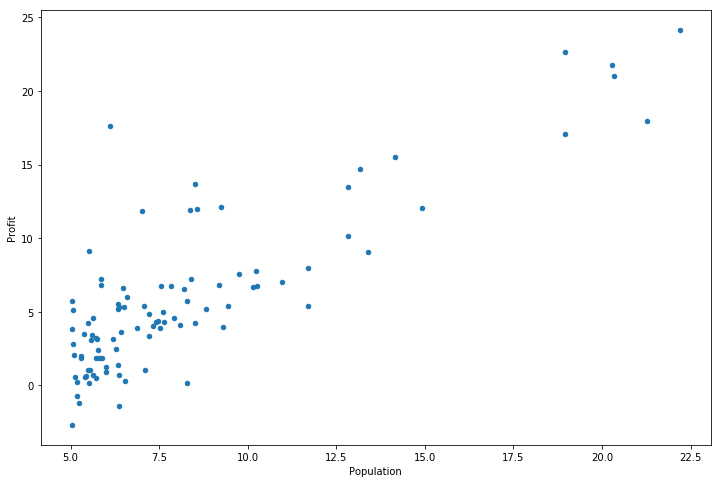

In [59]:
data.plot(kind='scatter', x='Population', y='Profit', figsize=(12,8))

### 경사강하(gradient descent)

이제 비용 함수를 최소화하기 위해 경사강하를 사용하여 선형회귀를 구현해 보겠습니다. 이 때 선형회귀 매개변수 $\theta$ 를 지정한다.

#### 방정식 업데이트
선형회귀의 목적은 다음과 같이 정의되는 비용함수를 최소화 하는 것이다.
$$J(\theta) = { 1 \over 2m}\sum_{i=1}^m (h_\theta ( x^{(i)}) - y^{(i)})^2$$
여기에서 가설 $h(x)$ 는 다음과 같은 선형모델로 주어진다.
$$h_\theta(x) = \mathbf {\theta^T x }= \theta_0 + \theta_1 x_1$$

모델의 매개변수는 $\theta_j$ 값 이라는 점을 상기하십시오. 비용 $J(\theta)$를 최소화하기 위해 조정할 값입니다. 이를 수행하는 한 가지 방법은 경사강하(gradient descent) 알고리즘을 사용하는 것입니다. 경사강하에서의 각 반복은 다음의 업데이트를 수행합니다.
$$ \theta_j := \theta_j - \alpha {1 \over m } \sum_{i=1}^m (h_\theta ( x^{(i)}) - y^{(i)}) x_j^{(i)} $$
여기에서 모든 $j$ 에 대하여 $\theta_j$를 동시에 갱신합니다.

경사하강의 각 단계에서 매개 변수 $\theta_j$ 는 최저 비용 $J(\theta)$ 를 달성할 최적 값에 더 가까워집니다.

#### 구현

훈련 자료에 1 열을 추가하여, 비용 및 그레디언트를 계산하기 위해 벡터화 된 솔루션을 사용할 수 있도록 하겠습니다.

In [60]:
data.insert(0, 'Ones', 1)

이제 몇 몇 변수들을 초기화를 해봅시다.

In [61]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]
print(cols)

3


X (훈련 세트)와 y (목표 변수)가 올바른지 확인해 봅시다.

In [62]:
X.head()

,Ones,Population
0,1,6.1101
1,1,5.5277
2,1,8.5186
3,1,7.0032
4,1,5.8598


In [63]:
y.head()

,Profit
0,17.5920
1,9.1302
2,13.6620
3,11.8540
4,6.8233


비용 함수는 numpy 행렬을 기대하기 때문에, 사용하기 전에 X와 y를 변환해야 합니다. 우리는 또한 $\theta$ 도 초기화해야 합니다.

In [64]:
X = np.matrix(X.values)
y = np.matrix(y.values)
theta = np.matrix(np.array([0,0]))

$\theta$ 는 다음과 같습니다.

In [65]:
theta

matrix([[0, 0]])

행렬의 모양을 간단히 살펴 보겠습니다.

In [10]:
X.shape, theta.shape, y.shape

((97, 2), (1, 2), (97, 1))

### 비용 $J(\theta)$의 계산

비용 함수 $J(\theta)$를 최소화하는 방법을 배우려면 기울기 강하를 수행하면서 비용을 계산하여 수렴을 모니터링하는 것이 좋습니다. 이 섹션에서는 $J(\theta)$를 계산하는 함수를 구현하여 그래디언트 강하 구현의 수렴을 확인할 수 있습니다.
다음 작업은 $J(\theta)$를 계산하는 함수인 computeCost() 코드를 완성하는 것입니다. 이 작업을 수행함에 따라 변수 $X$와 $y$는 스칼라 값이 아니라 행이 훈련 세트의 예제를 나타내는 행렬임을 기억하십시오. 

함수를 완료하면 $\theta$를 0으로 초기화하여 computeCost()를 한 번 실행하면 비용이 표시됩니다. 약 32.07의 비용을 기대해야합니다.

In [66]:
def computeCost(X, y, theta):
    inner = np.power(((X * theta.T) - y), 2)
    return np.sum(inner) / (2 * len(X))

computeCost(X, y, theta)

32.072733877455676

### 경사강하

다음은 gradientDescent() 함수에 그라디언트 디센트를 구현합니다. 루프 구조가 작성되었으며 각 반복에서 $\theta$에 대한 업데이트 만 제공하면 됩니다.

프로그램을 진행하면서 최적화하려는 내용과 업데이트되는 내용을 이해해야합니다. 비용 $J(\theta)$는 X와 y가 아닌 벡터 $\theta$에 의해 매개 변수화된다는 것을 명심하십시오. 즉, $X$ 또는 $y$를 변경하지 않고 벡터 $\theta$의 값을 변경하여 $J(\theta)$의 값을 최소화합니다. 

그래디언트 디센트가 올바르게 작동하는지 확인하는 좋은 방법은 $J(\theta)$의 값을 보고 각 단계마다 감소하는지 확인하는 것입니다. gradientDescent()의 모든 반복에서 computeCost()를 호출하고 비용을 인쇄합니다. 그래디언트 디센트와 computeCost()를 올바르게 구현했다고 가정하면, $J(\theta)$의 값은 절대로 증가해서는 안되며 알고리즘이 끝날 때까지 안정된 값으로 수렴해야합니다.

여태까지는 그런대로 잘됐다. 이제 위에 정의된 업데이트 규칙을 사용하여, 매개 변수 $\theta$에 대하여 경사하강을 수행하는 함수를 정의해야 합니다.

In [12]:
def gradientDescent(X, y, theta, alpha, niter):
    temp = np.matrix(np.zeros(theta.shape))
    parameters = int(theta.ravel().shape[1])
    cost = np.zeros(niter)
    
    for i in range(niter):
        error = (X * theta.T) - y
        
        for j in range(parameters):
            term = np.multiply(error, X[:,j])
            temp[0,j] = theta[0,j] - ((alpha / len(X)) * np.sum(term))
            
        theta = temp
        cost[i] = computeCost(X, y, theta)
        
    return theta, cost

몇 가지 추가 변수 (학습 속도 $\alpha$ 및 반복 수행 횟수 niter)를 초기화하십시오.

In [13]:
alpha = 0.01
niter = 1000

이제 경사하강 알고리즘을 실행하여, 우리의 매개변수인 $\theta$를 훈련 세트에 맞춥니다.

In [14]:
g, cost = gradientDescent(X, y, theta, alpha, niter)
g

matrix([[-3.24140214,  1.1272942 ]])

마지막으로 우리는 적합 매개 변수를 사용하여 훈련된 모델의 비용(오차)을 계산할 수 있습니다.

In [15]:
computeCost(X, y, g)

4.515955503078912

이제 선형 모델을 데이터와 함께 플롯하여 얼마나 잘 맞는지 눈으로 확인해 보겠습니다.

Text(0.5,1,'Predicted Profit vs. Population Size')

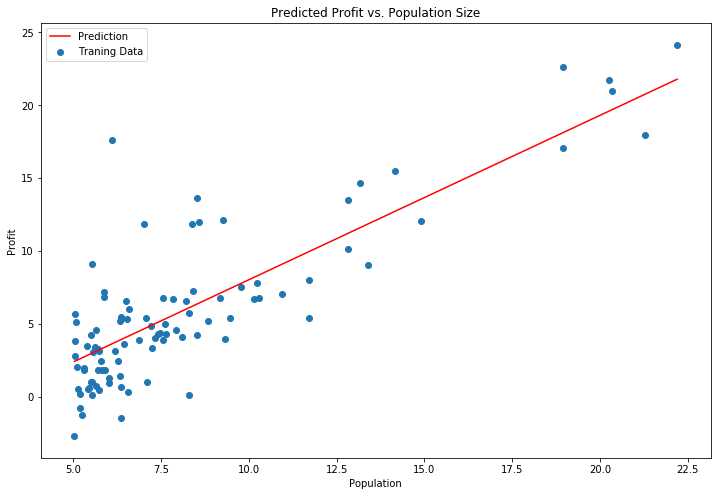

In [16]:
xs = np.linspace(data.Population.min(), data.Population.max(), 100)
f = g[0, 0] + (g[0, 1] * xs)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(xs, f, 'r', label='Prediction')
ax.scatter(data.Population, data.Profit, label='Traning Data')
ax.legend(loc=2)
ax.set_xlabel('Population')
ax.set_ylabel('Profit')
ax.set_title('Predicted Profit vs. Population Size')

꽤 좋아 보인다! 경사하강 함수는 각 학습 반복에서 비용이 든 벡터를 출력하기 때문에, 우리는 또한 그것을 플로팅 할 수 있습니다. 비용은 항상 감소합니다. 이는 볼록 최적화(convex optimization) 문제의 예입니다.

Text(0.5,1,'Error vs. Training Epoch')

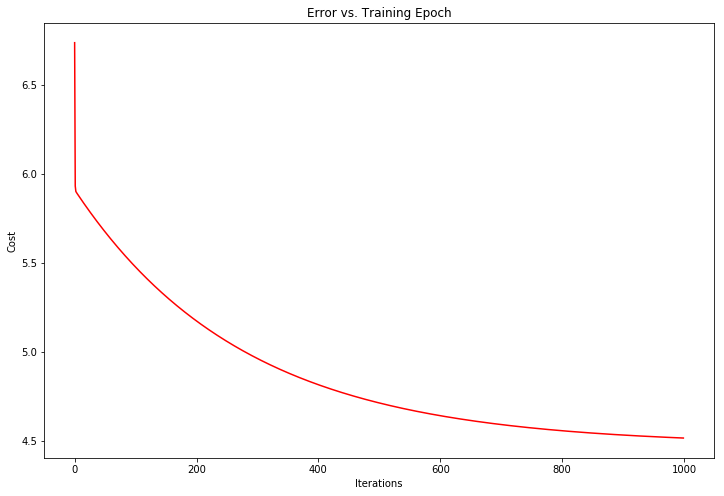

In [17]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(niter), cost, 'r')
ax.set_xlabel('Iterations')
ax.set_ylabel('Cost')
ax.set_title('Error vs. Training Epoch')

In [142]:
def steepestDescent(X, y, theta, alpha, niter):
    temp = np.matrix(np.zeros(theta.shape))
    parameters = int(theta.ravel().shape[1])
    cost = np.zeros(niter)
 
    for i in range(niter):
        error = (X * theta.T) - y
        
        for j in range(parameters):
            term = np.multiply(error, X[:,j])
            temp[0,j] = theta[0,j] - ((alpha / len(X)) * np.sum(term))
            
        theta = temp
        cost[i] = computeCost(X, y, theta)
        if i >= 1 :
            derror = np.subtract(error, error_old)
            alpha = error.T * derror / (derror.T * derror + 0.0001)
        error_old = error

    return theta, cost

alpha = 0.01
niter = 1000
theta = np.matrix(np.array([0,0]))
g, cost2 = steepestDescent(X, y, theta, alpha, niter)
g
computeCost(X, y, g)

/Users/Jun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in power
  
/Users/Jun/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/Users/Jun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


nan

### J(θ) 시각화

비용 함수 J(θ)를 더 잘 이해하기 위해 이제 $\theta_0$과 $\theta_1$값의 2 차원 그리드에 대한 비용을 표시해 봅니다. 이 부분에서 새로운 코드를 작성할 필요는 없지만 이러한 이미지를 만드는 이미 작성된 코드가 어떻게 작동하는지 이해해야 합니다.

다음의 코드는 작성한 computeCost 함수를 사용하여 값 표에 $J(\theta)$를 계산하도록 코드를 설정합니다. 이 행들이 실행 된 후에는 $J(\theta)$ 값의 2 차원 배열을 가집니다. 그런 다음 ex1.m 스크립트는이 값을 사용하여 surf 및 contour 명령을 사용하여 J(θ)의 표면 및 윤곽 플롯을 생성합니다. 

In [118]:
# initialize J vals to a matrix of 0's
theta0 = np.arange(-4,-1,0.05)
theta1 = np.arange(-0.5,2.5,0.05)
J_vals = np.zeros([np.size(theta0), np.size(theta1)])

for i in range(np.size(theta0)):
    for j in range(np.size(theta1)):
        thetas = np.matrix(np.array([theta0[i], theta1[j]]))
        J_vals[i,j] = computeCost(X, y, thetas)
        
J_vals[:10,:10]
thetas  = np.matrix(np.array([0,0]))
computeCost(X, y, g)

4.515955503078912

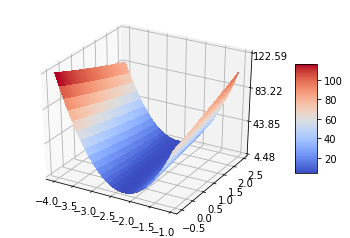

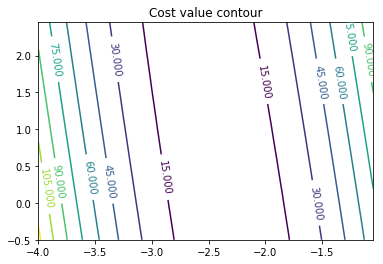

In [120]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.

T0, T1 = np.meshgrid(theta0, theta1)

# Plot the surface.
surf = ax.plot_surface(T0, T1, J_vals, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(0, 50)
ax.zaxis.set_major_locator(LinearLocator(4))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

fig, ax = plt.subplots()
CS = ax.contour(T0, T1, J_vals, 10)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Cost value contour')
plt.show()

## 다변량 선형회귀
연습 1에는 또한 2 개의 변수(주택 크기와 침실 수)와 목표(주택 가격)가 포함 된 주택 가격 데이터 세트가 포함되었습니다. 데이터 세트를 분석하기 위해 이미 적용한 기술을 사용합시다.

In [121]:
path = os.getcwd() + '/data/ex1data2.txt'
data2 = pd.read_csv(path, header=None, names=['Size', 'Bedrooms', 'Price'])
data2.head()

,Size,Bedrooms,Price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


이 작업을 위해 특징(feature)을 정규화하는(normalization) 또 다른 사전처리 단계를 추가합니다. 이것은 pandas 로 아주 쉽습니다.

In [122]:
data2 = (data2 - data2.mean()) / data2.std()
data2.head()

,Size,Bedrooms,Price
0,0.130010,-0.223675,0.475747
1,-0.504190,-0.223675,-0.084074
2,0.502476,-0.223675,0.228626
3,-0.735723,-1.537767,-0.867025
4,1.257476,1.090417,1.595389


이제 파트 1의 사전 처리 단계를 반복하고, 새로운 데이터 세트에 대한 선형회귀 절차를 실행해 봅시다.

In [123]:
# add ones column
data2.insert(0, 'Ones', 1)

# set X (training data) and y (target variable)
cols = data2.shape[1]
X2 = data2.iloc[:,0:cols-1]
y2 = data2.iloc[:,cols-1:cols]

# convert to matrices and initialize theta
X2 = np.matrix(X2.values)
y2 = np.matrix(y2.values)
theta2 = np.matrix(np.array([0,0,0]))

# perform linear regression on the data set
g2, cost2 = gradientDescent(X2, y2, theta2, alpha, niter)

# get the cost (error) of the model
computeCost(X2, y2, g2)

0.13070336960771892

이 과정의 진행 상황을 간략하게 살펴볼 수 있습니다.

Text(0.5,1,'Error vs. Training Epoch')

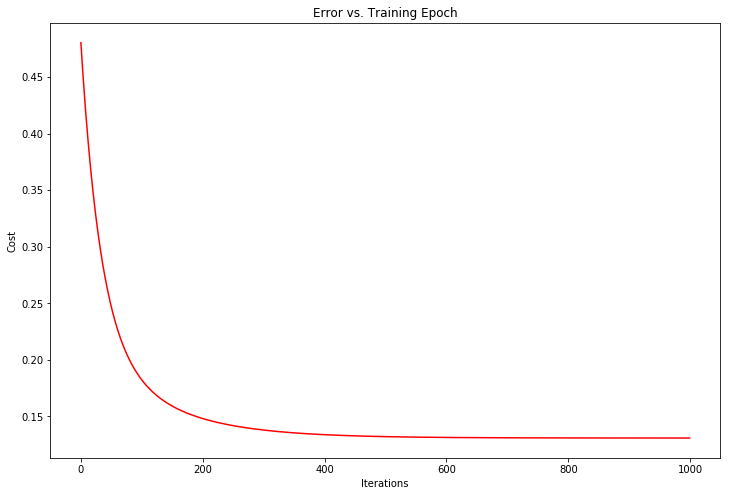

In [124]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(niter), cost2, 'r')
ax.set_xlabel('Iterations')
ax.set_ylabel('Cost')
ax.set_title('Error vs. Training Epoch')

이러한 알고리즘을 처음부터 구현하는 대신 scikit-learn의 선형회귀 함수를 사용할 수도 있습니다. 파트 1의 데이터에 scikit-learn의 선형 회귀 알고리즘을 적용하고 그 결과를 확인해 봅시다.

In [128]:
from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

scikit-learn 모델의 예측은 다음과 같습니다.

Text(0.5,1,'Predicted Profit vs. Population Size')

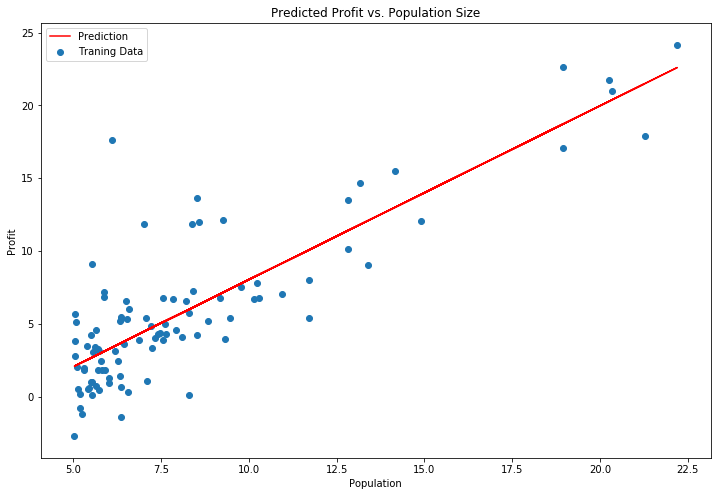

In [126]:
x = np.array(X[:, 1].A1)
f = model.predict(X).flatten()

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x, f, 'r', label='Prediction')
ax.scatter(data.Population, data.Profit, label='Traning Data')
ax.legend(loc=2)
ax.set_xlabel('Population')
ax.set_ylabel('Profit')
ax.set_title('Predicted Profit vs. Population Size')